In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import numpy as np
from plotly_resampler import FigureWidgetResampler
import plotly.graph_objects as go

# Construct the data
n = 1_000_000
x = np.arange(n)
y = np.sin(x/500) + np.random.randn(n)/15

# construct the figure
fw_fig = FigureWidgetResampler()
fw_fig.add_trace(go.Scattergl(), hf_x=x, hf_y=y)
fw_fig.update_layout(showlegend=True)

# just add a point to the point-list
point_list = []
def update_point(trace, points, selector):
    for point in points.xs:
        point_list.append(point)

        fw_fig.add_vline(x=point, line_color='black', line_width=2)

fw_fig.data[0].on_click(update_point)
fw_fig

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> trace 0 <i style="color:#fc…

In [25]:
point_list

[396583, 462531, 525358, 537527, 540984]

In [3]:
import json

from pathlib import Path
import pandas as pd
import librosa
from functional import seq
from uuid import uuid4

import sys

sys.path.append("..")
from sgs_utils.path_conf import (
    speech_data_root_dir,
    speech_data_session_dir,
    loc_data_dir,
)


In [3]:
# !wget --output-document="speech_data_webapp.zip" https://cloud.ilabt.imec.be/index.php/s/tB2enWmZCJskGmG/download 
# !unzip speech_data_webapp.zip
# !mv speech_web_app /project_scratch/data/
# !rm speech_data_webapp.zip

In [4]:
# so we have all folders in backup?
!ls -lh {speech_data_session_dir} | head -n 10

total 0
drwxr-xr-x 2 root root  35 Apr 28 08:55 2020-11-25__11:08:00+01:00__59b7f538-755a-4bee-8165-158c6795b287
drwxr-xr-x 6 root root 107 Apr 28 08:55 2020-11-25__11:11:00+01:00__6fb54909-8b1d-4ff5-bc58-912249de7d94
drwxr-xr-x 2 root root  35 Apr 28 08:55 2020-11-25__11:13:00+01:00__12cd1ed1-17ae-4a4c-8fa8-1363030736e7
drwxr-xr-x 2 root root  35 Apr 28 08:55 2020-11-25__11:33:00+01:00__9247ce5d-23af-4af4-bb07-6c9b53f8bb90
drwxr-xr-x 4 root root  70 Apr 28 08:55 2020-11-25__11:35:00+01:00__8c449866-0ac4-4b62-a4a7-d3ce0e7781b6
drwxr-xr-x 3 root root  51 Apr 28 08:55 2020-11-25__11:45:00+01:00__a03a23eb-ca38-430d-afc6-e47dc4d71f61
drwxr-xr-x 2 root root  35 Apr 28 08:55 2020-11-25__11:53:00+01:00__8071ebfc-e589-4175-900b-0fadf2627aa5
drwxr-xr-x 2 root root  35 Apr 28 08:55 2020-11-25__11:54:00+01:00__f752870e-8461-4b7f-bdcc-93649b8caeaa
drwxr-xr-x 2 root root  35 Apr 28 08:55 2020-11-25__12:15:00+01:00__2f87494b-5d33-46b3-8595-a4da6510ab1f


In [5]:
# This snippet summarizes the dir-names of the various folders
# within `speech_session_dir`
dir_list = []
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue
    dir_list.extend(
        seq(folder.iterdir())
        .filter(lambda x: x.is_dir())
        .map(lambda x: x.name)
        .to_list()
    )
print(pd.Series(dir_list).value_counts())
del dir_list, folder


marloes    50
PiSCES     42
Radboud    38
demo        5
dtype: int64


## Creating the metadata file

The metadata file is constructed of the `.json` file which resides within each user ID 
folder and withholds the person's metadata such as gender, age, education, used mic. etc ...

In [6]:
metadata_dict_list = []

# creating alldata.csv
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    metadata = folder.joinpath("metadata.json")
    if not metadata.is_file():
        continue

    with open(metadata, "r") as f:
        metadata_dict = json.load(f)
    metadata_dict["ID"] = folder.name.split("__")[-1]

    metadata_dict["Marloes"] = len(list(folder.joinpath("marloes").glob("*.wav")))
    metadata_dict["PiSCES"] = len(list(folder.joinpath("PiSCES").glob("*.wav")))
    metadata_dict["Radboud"] = len(list(folder.joinpath("Radboud").glob("*.wav")))

    metadata_dict_list.append(metadata_dict)

df_metadata = pd.DataFrame(metadata_dict_list)

# conver the columns to the correct data format
df_metadata["age"] = df_metadata["age"].astype(int)
df_metadata[["sex", "device", "education"]] = df_metadata[
    ["sex", "device", "education"]
].astype("category")
df_metadata["timestamp"] = pd.to_datetime(df_metadata.timestamp).dt.tz_convert(
    "europe/brussels"
)
del folder, metadata_dict, metadata_dict_list, f, metadata


In [7]:
df_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype                          
---  ------     --------------  -----                          
 0   age        112 non-null    int64                          
 1   education  112 non-null    category                       
 2   sex        112 non-null    category                       
 3   timestamp  112 non-null    datetime64[ns, Europe/Brussels]
 4   ID         112 non-null    object                         
 5   Marloes    112 non-null    int64                          
 6   PiSCES     112 non-null    int64                          
 7   Radboud    112 non-null    int64                          
 8   device     39 non-null     category                       
dtypes: category(3), datetime64[ns, Europe/Brussels](1), int64(4), object(1)
memory usage: 6.2+ KB


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

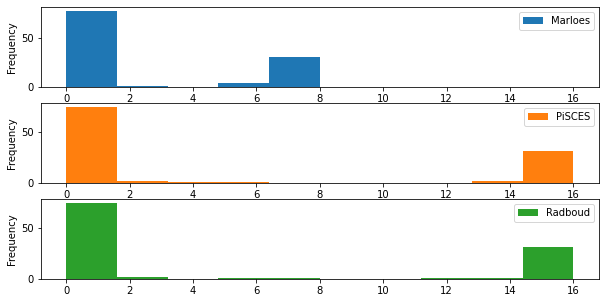

In [8]:
df_metadata[["Marloes", "PiSCES", "Radboud"]].plot(
    subplots=True, kind="hist", figsize=(10, 5), sharex=False
)

In [9]:
df_metadata_relevant = (
    df_metadata[
        (df_metadata.Marloes >= 6)
        & (df_metadata.Radboud >= 15)
        & (df_metadata.PiSCES >= 15)
    ]
    .reset_index(drop=True)
    .copy()
)

In [10]:
df_metadata_relevant.columns

Index(['age', 'education', 'sex', 'timestamp', 'ID', 'Marloes', 'PiSCES',
       'Radboud', 'device'],
      dtype='object')

In [11]:
df_metadata_relevant[
    ["age", "sex", "device", "Marloes", "PiSCES", "Radboud"]
].describe()


,age,Marloes,PiSCES,Radboud
count,31.000000,31.000000,31.000000,31.0
mean,28.548387,6.935484,15.064516,15.0
std,5.182269,0.249731,0.249731,0.0
min,20.000000,6.000000,15.000000,15.0
25%,25.000000,7.000000,15.000000,15.0
50%,28.000000,7.000000,15.000000,15.0
75%,30.000000,7.000000,15.000000,15.0
max,39.000000,7.000000,16.000000,15.0


In [12]:
# There is a 2-to-1 imbalance in gender
df_metadata_relevant.sex.value_counts()

male      21
female    10
other      0
Name: sex, dtype: int64

In [13]:
df_metadata_relevant.device.value_counts()

pc-mic       8
earphones    6
headset      4
other        1
Name: device, dtype: int64

In [14]:
df_metadata_relevant.education.value_counts()

unif    27
ho       2
so       2
lo       0
Name: education, dtype: int64

array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

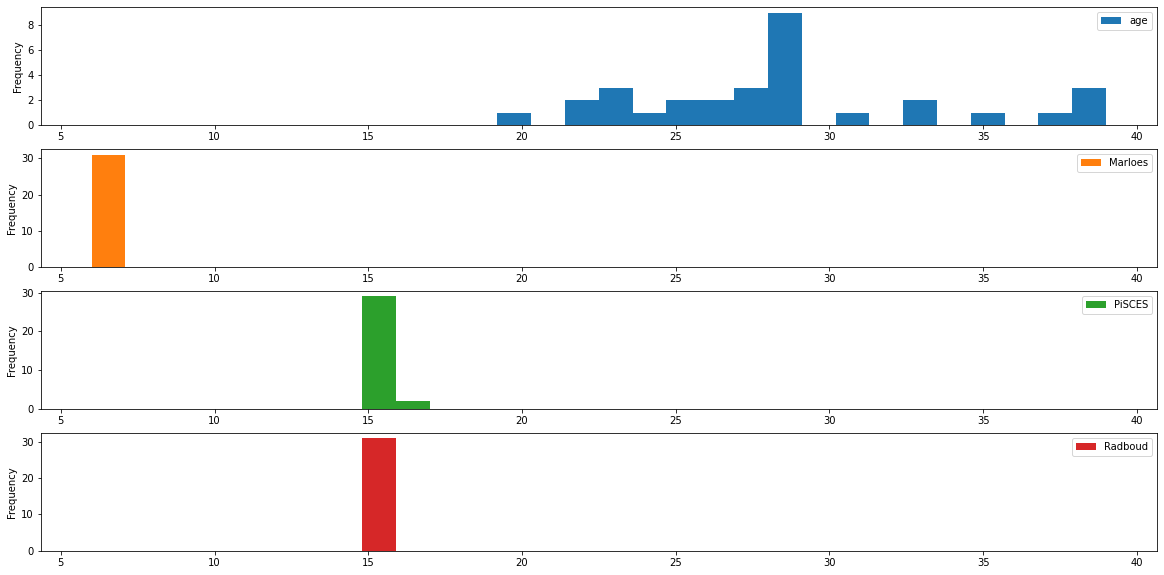

In [15]:
df_metadata_relevant[["age", "sex", "device", "Marloes", "PiSCES", "Radboud"]].plot(
    kind="hist", bins=30, subplots=True, sharex=False, figsize=(20, 10)
)


In [16]:
df_metadata_relevant.to_parquet(loc_data_dir.joinpath("metadata_rel_ids.parquet"))

## Distilling sessions from the relevant metadata

In [17]:
session_dict_list = []

# creating alldata.csv
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    def parse_pic_name_ts(db_folder, pic_name, time_str, sep="__") -> dict:
        # what can we save from the wave file?
        # duration - size
        json_f = sep.join([pic_name, time_str]) + ".json"
        json_f = db_folder.joinpath(json_f)
        if not json_f.is_file():
            # print('json_f does not exist')
            return {}

        with open(json_f, "r") as f:
            return json.load(f)

    # TODO -> maybe we can also use the wav duration here as an extra assert.
    def get_wav_json_mapping(db_folder: Path) -> dict:
        # parse the wav files to construct a dataframe
        wav_list = list(db_folder.glob("*.wav"))
        df_db_wav = pd.Series(
            seq(wav_list).map(lambda x: x.name), name="wav_files", dtype="str"
        ).to_frame()
        df_db_wav["wav_time_str"] = df_db_wav["wav_files"].map(
            lambda x: x.split("__")[1].split(".")[0]
        )
        df_db_wav["wav_time_str"] = pd.to_datetime(
            "2022/01/01 " + df_db_wav["wav_time_str"], infer_datetime_format=True
        )
        df_db_wav = df_db_wav.sort_values(by="wav_time_str")

        # parse the json files to construct a datafraem
        json_list = list(db_folder.glob("*.json"))
        df_db_json = pd.Series(
            seq(json_list).map(lambda x: x.name), name="json_files", dtype="str"
        ).to_frame()
        df_db_json["json_time_str"] = df_db_json["json_files"].map(
            lambda x: x.split("__")[1].split(".")[0]
        )
        df_db_json["json_time_str"] = pd.to_datetime(
            "2022/01/01 " + df_db_json["json_time_str"], infer_datetime_format=True
        )
        df_db_json = df_db_json.sort_values(by="json_time_str")

        json_wav_mapping = pd.merge_asof(
            left=df_db_wav,
            right=df_db_json,
            left_on="wav_time_str",
            right_on="json_time_str",
            tolerance=pd.Timedelta(minutes=3),
            # A "forward" search selects the first row in the right DataFrame whose 'on' key
            # is greater than or equal to the left's key.
            direction="forward",
        )

        json_wav_mapping = json_wav_mapping.dropna(how="any", axis=0)
        json_wav_mapping = json_wav_mapping[
            ~(
                json_wav_mapping["wav_time_str"]
                < json_wav_mapping["json_time_str"].shift(1)
            )
        ].reset_index(drop=True)

        assert all(
            (
                json_wav_mapping["json_time_str"].shift(1)
                < json_wav_mapping["wav_time_str"]
            ).values[1:]
        )
        wav_json_mapping_dict = (
            json_wav_mapping[["json_files", "wav_files"]]
            .set_index("wav_files")
            .to_dict()["json_files"]
        )
        return wav_json_mapping_dict

    for db_folder in [folder.joinpath(x) for x in ["marloes", "Radboud", "PiSCES"]]:
        wav_json_mapping_dict = get_wav_json_mapping(db_folder)

        for wav_file in db_folder.glob("*.wav"):
            pic_name, time_str = wav_file.name.split("__")
            metadata_dict = parse_pic_name_ts(db_folder, pic_name, time_str)
            metadata_dict["pic_name"] = pic_name
            metadata_dict["time_str"] = time_str.split(".")[0]
            metadata_dict["wav_size"] = wav_file.stat().st_size
            metadata_dict["wav_duration_s"] = librosa.get_duration(filename=wav_file)
            metadata_dict["ID"] = db_folder.parent.name.split("__")[-1]
            metadata_dict["DB"] = db_folder.name

            # also read the json file to fetch the arousal and valence values
            if wav_file.name in wav_json_mapping_dict:
                with open(
                    db_folder.joinpath(wav_json_mapping_dict[wav_file.name]), "r"
                ) as f:
                    json_dct = json.load(f)
                    metadata_dict["arousal"] = int(json_dct.get("arousal"))
                    metadata_dict["valence"] = int(json_dct.get("valence"))

            session_dict_list.append(metadata_dict)

df_session = pd.DataFrame(session_dict_list)
del (
    folder,
    db_folder,
    wav_file,
    metadata_dict,
    session_dict_list,
    time_str,
    pic_name,
    f,
    wav_json_mapping_dict,
    json_dct,
)


In [18]:
df_session.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pic_name        1267 non-null   object 
 1   time_str        1267 non-null   object 
 2   wav_size        1267 non-null   int64  
 3   wav_duration_s  1267 non-null   float64
 4   ID              1267 non-null   object 
 5   DB              1267 non-null   object 
 6   arousal         1256 non-null   float64
 7   valence         1256 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 79.3+ KB


In [19]:
df_session_tot = df_metadata_relevant.merge(
    df_session, how="left", left_on="ID", right_on="ID"
)
df_session_tot


,age,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,device,pic_name,time_str,wav_size,wav_duration_s,DB,arousal,valence
0,26,so,male,2020-11-26 09:48:19.292420+01:00,a97a84b6-7a66-461f-810e-b54bac686f64,7,15,15,NaN,marloes,09:54:08,1892396,21.455238,marloes,0.0,10.0
1,26,so,male,2020-11-26 09:48:19.292420+01:00,a97a84b6-7a66-461f-810e-b54bac686f64,7,15,15,NaN,marloes,09:56:34,139308,1.578957,marloes,76.0,65.0
2,26,so,male,2020-11-26 09:48:19.292420+01:00,a97a84b6-7a66-461f-810e-b54bac686f64,7,15,15,NaN,marloes,09:57:31,106540,1.207438,marloes,97.0,67.0
3,26,so,male,2020-11-26 09:48:19.292420+01:00,a97a84b6-7a66-461f-810e-b54bac686f64,7,15,15,NaN,marloes,09:58:00,41004,0.464399,marloes,30.0,19.0
4,26,so,male,2020-11-26 09:48:19.292420+01:00,a97a84b6-7a66-461f-810e-b54bac686f64,7,15,15,NaN,marloes,09:58:37,32812,0.371519,marloes,35.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Picture 87,16:45:23,6168620,64.256000,PiSCES,56.0,58.0
1143,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Picture 88,17:03:12,8355884,87.040000,PiSCES,64.0,63.0
1144,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Picture 93,16:57:01,11018284,114.773333,PiSCES,66.0,64.0
1145,27,unif,female,2020-12-14 16:26:16.730052+01:00,fb807c80-22cc-4964-81a0-8c732f572004,7,15,15,earphones,Picture 96,17:00:09,5832748,60.757333,PiSCES,61.0,56.0


In [20]:
# I think it is fair to just use the plain replace function and assume that nobody
# had a day-change
df_session_tot.time_str.sort_values()


129    08:28:22
134    08:30:36
123    08:31:58
133    08:33:18
111    08:33:53
         ...   
807    22:51:48
790    22:53:56
800    22:55:38
793    22:58:10
782    22:59:38
Name: time_str, Length: 1147, dtype: object

<AxesSubplot:ylabel='Frequency'>

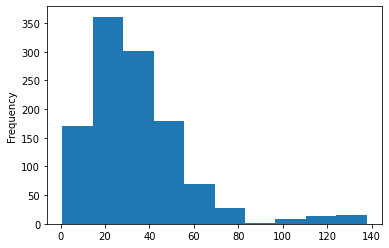

In [21]:
# create the time-columns in which the time-str and the timestamp are merged
df_session_tot["time"] = df_session_tot.apply(
    lambda r: r.timestamp.replace(
        **dict(zip(["hour", "minute", "second"], list(map(int, r.time_str.split(":")))))
    ),
    axis=1,
)
((df_session_tot.time - df_session_tot.timestamp).dt.total_seconds() / 60).plot.hist()


In [22]:
import numpy as np

test_arr = [1, 10, 3, 5, 2, 8, 100, 12, 200]
print(np.array(test_arr))
print(np.argsort(test_arr))
print(1 + np.argsort(np.argsort(test_arr)))


[  1  10   3   5   2   8 100  12 200]
[0 4 2 3 5 1 7 6 8]
[1 6 3 4 2 5 8 7 9]


In [23]:
df_session_tot["DB_no"] = df_session_tot.groupby(["ID", "DB"])["time"].apply(
    lambda s: 1 + s.argsort().argsort()
)
df_session_tot["session_no"] = df_session_tot.groupby(["ID"])["time"].apply(
    lambda s: 1 + s.argsort().argsort()
)

df_session_tot["pic_no"] = None
pic_mask = df_session_tot.DB != "marloes"
df_session_tot.loc[pic_mask, "pic_no"] = (
    df_session_tot[pic_mask]
    .groupby(["ID"])
    .time.apply(lambda s: 1 + s.argsort().argsort())
)


### Duration based visualizations

In [35]:
pv = df_session_tot[["DB", "wav_duration_s"]].pivot(
    columns="DB", values="wav_duration_s"
)
pv

DB,PiSCES,Radboud,marloes
0,NaN,NaN,21.455238
1,NaN,NaN,1.578957
2,NaN,NaN,1.207438
3,NaN,NaN,0.464399
4,NaN,NaN,0.371519
...,...,...,...
1142,64.256000,NaN,NaN
1143,87.040000,NaN,NaN
1144,114.773333,NaN,NaN
1145,60.757333,NaN,NaN


In [37]:
pd.options.plotting.backend = 'plotly'

In [41]:
import plotly.express as px

In [48]:
help(px.histogram)

Help on function histogram in module plotly.express._chart_types:

histogram(data_frame=None, x=None, y=None, color=None, pattern_shape=None, facet_row=None, facet_col=None, facet_col_wrap=0, facet_row_spacing=None, facet_col_spacing=None, hover_name=None, hover_data=None, animation_frame=None, animation_group=None, category_orders=None, labels=None, color_discrete_sequence=None, color_discrete_map=None, pattern_shape_sequence=None, pattern_shape_map=None, marginal=None, opacity=None, orientation=None, barmode='relative', barnorm=None, histnorm=None, log_x=False, log_y=False, range_x=None, range_y=None, histfunc=None, cumulative=None, nbins=None, text_auto=False, title=None, template=None, width=None, height=None)
        In a histogram, rows of `data_frame` are grouped together into a
        rectangular mark to visualize the 1D distribution of an aggregate
        function `histfunc` (e.g. the count or sum) of the value `y` (or `x` if
        `orientation` is `'h'`).
        
    Par

In [55]:
px.histogram(
    df_session_tot[["DB", "wav_duration_s"]].pivot(
        columns="DB", values="wav_duration_s"
    ),
    nbins=100,
    facet_row="DB",
    height=800,
    opacity=0.5,
)


is het fair om de assumptie te maken dat niemand middernacht de app heeft gebruikt?

### Investigating the file duration

In [57]:
(df_session_tot.wav_duration_s < 5).value_counts()


False    1101
True       46
Name: wav_duration_s, dtype: int64

In [62]:
(df_session_tot.wav_duration_s < 15).value_counts()


False    1095
True       52
Name: wav_duration_s, dtype: int64

In [28]:
df_session_tot[(df_session_tot.wav_duration_s < 1)].groupby(
    ["ID", "DB"]
).size().to_frame()


0
ID                                   DB        
0bae55f8-2aab-4c7b-917f-7f0c3e627e5f marloes  1
2b9fffea-9eea-43cc-9f1a-f026cbb4a19b marloes  1
3bdd33ef-9671-4a3e-b152-eff41ef674e8 marloes  2
716dc108-5588-49ed-bf3c-04fb87212e2b Radboud  2
94025116-4e19-4718-9e4e-c9f5af205b4c Radboud  1
                                     marloes  1
9c44a144-8722-4d83-9bc7-f3c1189c5b82 Radboud  1
                                     marloes  1
a97a84b6-7a66-461f-810e-b54bac686f64 PiSCES   7
                                     Radboud  6
                                     marloes  3
aef8bb4e-230d-42ae-a76a-dc5b37d97ff3 Radboud  1
bca36751-bfcb-42a7-bffd-b418e606f1ca PiSCES   1

### Filtering events

In [29]:
df_session_tot.shape

(1147, 20)

In [30]:
ids_to_skip = ["a97a84b6-7a66-461f-810e-b54bac686f64"]
# we also skip this id
df_session_tot[(~df_session_tot.ID.isin(ids_to_skip)) & (df_session_tot.wav_size > 100)]
df_session_tot = df_session_tot.sort_values(by=['ID', 'time'], ignore_index=True)

In [31]:
df_session_tot["uuid"] = [str(uuid4()) for _ in range(len(df_session_tot))]

In [32]:
df_session_tot.to_parquet(loc_data_dir.joinpath('df_session_tot_uuid.parquet'))